In [1]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### 生成数据集

In [3]:
batch_size = 100
workers = 0
image_size = 64
ngpu = 1

In [4]:
root = 'data/celeba' #本次只使用了3000张图片，只是做一次尝试。
dataset = torchvision.datasets.ImageFolder(root=root,
                                           transform=transforms.Compose([
                                               transforms.Resize(64),
                                               transforms.CenterCrop(64),
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                           ]))

In [5]:
# creat the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
	shuffle=True, num_workers=workers)

# device which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

### 展示一些训练的照片

torch.Size([100, 3, 64, 64]) torch.Size([100])


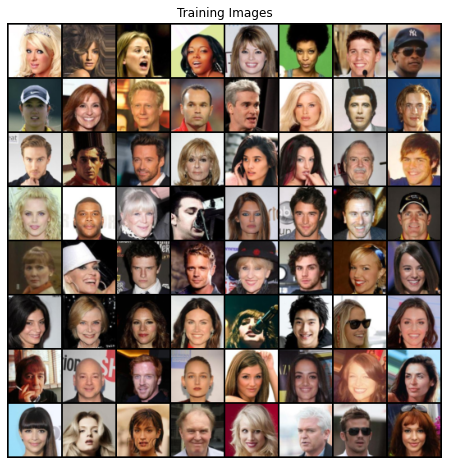

In [10]:
real_batch = next(iter(dataloader))
#real_batch是一个列表
#第一个元素real_batch[0]是[100,3,64,64]的tensor，就是标准的一个batch的4D结构：128张图，3个通道，64长，64宽
#第二个元素real_batch[1]是第一个元素的标签，有100个label值全为0

print(real_batch[0].shape,real_batch[1].shape)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64].to(device), nrow=8, padding=2, normalize=True).cpu(),(1,2,0)))

In [12]:
print(real_batch[0][:64].shape)

torch.Size([64, 3, 64, 64])


### 构建模型

这里有几个参数是需要说明的，

nz表示输入的z的长度，

nc表示通过G生成的模型有三个通道，

ngf表示最后生成的图片的特征为64*64大小

In [13]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

### 生成器

In [17]:
noise = torch.randn(100, nz, 1, 1, device=device)
noise.shape

torch.Size([100, 100, 1, 1])

In [ ]:
class Generator(nn.Module):
    def __init__(self,ngpu):
        super(Generator,self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential()